In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import os
import sys

import fmax as fm

# Get min/max from a sequence of attempts

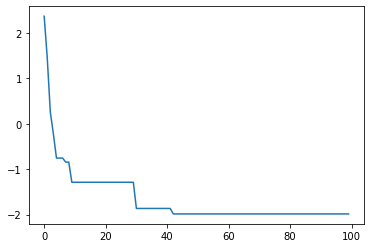

In [4]:
plt.plot(fm.get_min(np.random.randn(100)))
plt.show()

In [3]:
fm.jump_flat_split(fm.get_min(np.random.randn(100)), kind="min")

(array([ 0.21753664, -0.33726242, -1.58328904, -3.78187171]),
 array([-0.33726242, -1.58328904, -1.58328904, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3.78187171,
        -3.78187171, -3.78187171, -3.78187171, -3.78187171, -3

# Fit a model

In [12]:
os.chdir(sys.path[0]+"/../data")
df = pd.read_csv("olympics_athletic_gold_medal_times.csv")
df.head()

,Unnamed: 0,category,year,time,reference
0,0,"100 metres, Men",1896,12.0,http://www.olympedia.org/results/56000
1,1,"400 metres, Men",1896,54.2,http://www.olympedia.org/results/56006
2,2,"800 metres, Men",1896,131.0,http://www.olympedia.org/results/56011
3,3,"110 metres Hurdles, Men",1896,17.6,http://www.olympedia.org/results/56018
4,4,"100 metres, Men",1900,11.0,http://www.olympedia.org/results/56034


In [13]:
# Get list of categories
categories = list(df["category"].unique())

# Get subset of just the first one
category = categories[0]
subset = df[df["category"] == category]

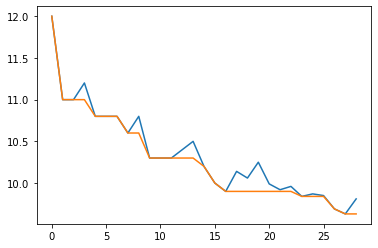

In [14]:
raw_data = subset['time'].values
min_series = fm.get_min(raw_data)

plt.plot(raw_data)
plt.plot(min_series)
plt.show()

In [7]:
jump_data, flat_data = fm.jump_flat_split(min_series, kind="min")

with pm.Model() as model:
    mu = pm.Normal('mu', mu=11.0, sigma=3.0)
    sigma = pm.Exponential('sigma', lam=1.0)
    loglike = fm.gaussian_attempts
    likelihood = pm.DensityDist('running_max', loglike, random=fm.gaussian_random(), 
                                observed = {'jump_data':jump_data, 
                                            'flat_data':flat_data, 
                                            'mu': mu, 
                                            'sigma': sigma})

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 52 seconds.


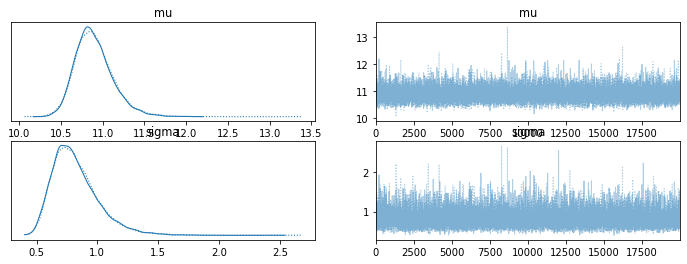

In [8]:
with model:
  trace = pm.sample(draws=20000, chains=2, tune=5000, target_accept=0.99,
                    return_inferencedata=True, 
                    idata_kwargs={"density_dist_obs": False})
pm.plot_trace(trace, ['mu', 'sigma']);

In [67]:
class ForecastModel:
    """Model class for handling forecasting given observed sequence of attempts.
    """
    def __init__(self, record_data, time_index=None, kind="max", attempts="gaussian", train="all", fcast_len=30):
        self.record_data = record_data
        self.kind = kind
        self.attempts = attempts
        self.n_obs = len(record_data)
        self.train = train
        self.fcast_len = fcast_len

        # Handle time index
        if time_index is None:
            self.master_index = [i for i in range(self.n_obs)]
            self.fcast_index = [i for i in range(self.n_obs, self.fcast_len)]
            self.master_with_fcast_index = [i for i in range(self.n_obs+self.fcast_len)]
            self.tot_index_len = self.n_obs + self.fcast_len
        else:
            print("I haven't done this case yet...")
            self.master_index = time_index

        # Split into training and testing:
        if self.train == "all":
            self.train_data = self.record_data
            self.train_index = self.master_index
            self.test_data = None
            self.test_index = None
        else:
            idx_train_max = int(train*len(self.master_index))
            self.train_data = self.record_data[:idx_train_max]
            self.train_index = self.master_index[:idx_train_max]
            self.test_data = self.record_data[idx_train_max:]
            self.test_index = self.master_index[idx_train_max:]
            self.fcast_index = [i for i in range(len(self.train_index) + self.fcast_len)]

        # Get jump/flat data
        self.jump_data, self.flat_data = fm.jump_flat_split(self.train_data, kind=self.kind)


    def fit(self, attempts_mean_mu=11, attempts_mean_sigma=3,
                            attempts_stdev_lam=1):
        """Fits a PyMC model to the training data.
        """

        # WIP: figure out how to choose priors reasonably from data

        with pm.Model() as self.pymc_model:
            mu = pm.Normal('mu', mu=attempts_mean_mu, sigma=attempts_mean_sigma)
            sigma = pm.Exponential('sigma', lam=attempts_stdev_lam)

        if self.attempts == "gaussian":
            
            random_sampler = fm.gaussian_random(n_periods=self.tot_index_len, past_obs=self.train_data)

            with self.pymc_model:
                loglike = fm.gaussian_attempts
                #global fm.gaussian_random
                likelihood = pm.DensityDist('running_max', loglike, random=random_sampler, 
                                observed = {'jump_data':jump_data, 
                                            'flat_data':flat_data, 
                                            'mu': mu, 
                                            'sigma': sigma})
        else:
            
            raise NotImplementedError

        with self.pymc_model:
            
            self.trace = pm.sample(draws=20000, chains=2, tune=5000, cores=1, target_accept=0.99,
                    return_inferencedata=True, 
                    idata_kwargs={"density_dist_obs": False})            


    def draw_forecasts(self):
        """Samples the posterior predictive (includes past and future).
        """                    
        with self.pymc_model:
            self.ppc = pm.sample_posterior_predictive(self.trace)


    

        


In [68]:
model = ForecastModel(min_series, kind="min", train=0.5)
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 71 seconds.


In [48]:
model.draw_forecasts()

In [51]:
model.ppc['running_max'].shape

(40000, 59)

In [63]:
def plot_posterior_predictive(fcast_model):
    """Simple plot of the posterior predictive of a forecast model.
    """

    sample_paths = fcast_model.ppc['running_max']
    index = fcast_model.fcast_index

    # Calculate the 1%, 10%, 50%, 90%, and 99% quantiles
    lower_bound_one = np.quantile(sample_paths, q=0.01, axis=0)
    lower_bound_ten = np.quantile(sample_paths, q=0.1, axis=0)
    medians = np.quantile(sample_paths, q=0.5, axis=0)
    upper_bound_ninety = np.quantile(sample_paths, q=0.9, axis=0)
    upper_bound_ninety_nine = np.quantile(sample_paths, q=0.99, axis=0)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(13,8))

    # Plot sample paths on the left
    axs[0].plot(index, sample_paths[:10000,:].T, alpha=0.05)
    axs[0].plot(fcast_model.train_index, fcast_model.train_data, color="red", label="Training")
    axs[0].plot(fcast_model.test_index, fcast_model.test_data, color="black", label="Testing")
    axs[0].legend()
    axs[0].set_xlabel("Period")
    axs[0].set_ylabel("Record")
    axs[0].set_title("Many Posterior Predictive Sample Paths")


    # Plot CI on the right
    axs[1].fill_between(index, lower_bound_one, upper_bound_ninety_nine, alpha=0.4, label="99% CI", color="C0")
    axs[1].fill_between(index, lower_bound_ten, upper_bound_ninety, alpha=0.7, label="80% CI", color="C0")
    axs[1].plot(index, medians, label="Median")
    axs[1].plot(fcast_model.train_index, fcast_model.train_data, color="red", label="Training")
    axs[1].plot(fcast_model.test_index, fcast_model.test_data, color="black", label="Testing")
    axs[1].legend()
    axs[1].set_xlabel("Period")
    axs[1].set_ylabel("Record")
    axs[1].set_title("Credible Interval Over Posterior Predictive Sample Paths")

    fig.tight_layout()

    return fig

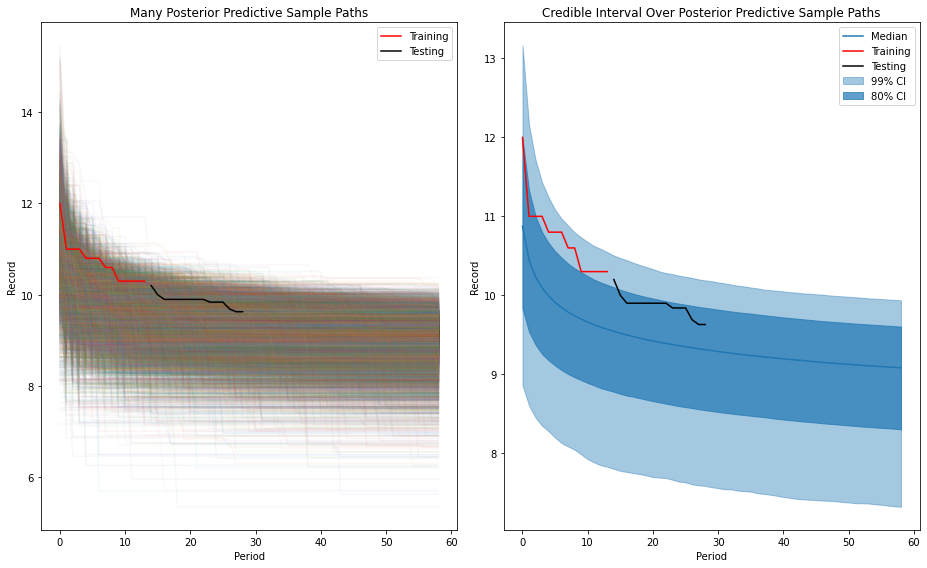

In [64]:
fig = plot_posterior_predictive(model)